In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

%matplotlib inline

register_matplotlib_converters()
sns.set(style="darkgrid", font_scale=1.5)

LENGTH = 200
LOOK_AHEAD_LENGTH = 40

# Train Model

In [18]:
def preprocessTestingData(data, length, look_ahead_length):
    """
    Returns a tuple of hist and target, the two datasets needed for training/testing
    params:
        data                a numpy array of the data: 1D
        length              an int, how many past frames should be used in prediction
        look_ahead_length   how many future frames ahead to predict each time
    """
    hist = []
    target = []

    for i in range(len(data)-length-look_ahead_length):
        x = data[i:i+length]
        y = data[i+length:i+length+look_ahead_length]
        hist.append(x)
        target.append(y)
    
    # Convert into numpy arrays and shape correctly (len(dataset), length) and (len(dataset), 1) respectivly
    hist = np.array(hist)
    target = np.array(target)
    # target = target.reshape(-1,1)

    #Reshape the input into (len(dataset), length, 1)
    hist = hist.reshape((len(hist), length, 1))

    return(hist, target)

In [19]:
def trainModel(datasets, length, model=None, quiet=False):
    for dataset in datasets:
        X_train, y_train = preprocessTestingData(dataset, length, LOOK_AHEAD_LENGTH)

        if not model:
            # Create model and compile if not already passed a model
            model = tf.keras.Sequential()
            model.add(layers.LSTM(units=32, return_sequences=True, input_shape=(length,1), dropout=0.2))
            # model.add(layers.LSTM(input_shape=(length,1), output_dim=hidden_neurons, return_sequences=False))  
            # model.add(layers.RepeatVector(LOOK_AHEAD_LENGTH))
            model.add(layers.LSTM(units=256, return_sequences=False, dropout=0.2))
            model.add(layers.Dense(LOOK_AHEAD_LENGTH))
            # model.add(layers.Activation('linear'))  

            # # model.add(layers.LSTM(units=32, return_sequences=True, dropout=0.2))
            # model.add(layers.LSTM(units=32, dropout=0.2))
            # # model.add(layers.Dense(units=LOOK_AHEAD_LENGTH))
            # model.add(layers.TimeDistributed(layers.Dense(1)))
            # model.add(Activation('linear'))  
            model.compile(optimizer='adam', loss='mean_squared_error')
            print(model.summary())

        # Perform training
        output = 1
        if quiet:
            output = 0
        history = model.fit(X_train, y_train, epochs=25, batch_size=320, verbose=output, shuffle=False)

        # Show loss
        if not quiet:
            loss = history.history['loss']
            epoch_count = range(1, len(loss) + 1)
            plt.figure(figsize=(6,4))
            plt.plot(epoch_count, loss, 'r--')
            plt.legend(['Training Loss'])
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()

    return model

In [20]:
def scaleData(paths):
    scaler = MinMaxScaler()
    datasets = []
    for path in paths:
        # perform partial fits on all datasets
        
        new_df = pd.DataFrame()
        new_df["price"] = pd.read_csv(path)[["high_price","low_price"]].mean(axis=1)
        datasets.append(new_df)

        scaler = scaler.partial_fit(datasets[-1])
    for i in range(len(datasets)):
        # once all partial fits have been performed, transform every file
        datasets[i] = scaler.transform(datasets[i])
    return (datasets, scaler)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 200, 32)           4352      
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               295936    
_________________________________________________________________
dense_2 (Dense)              (None, 40)                10280     
Total params: 310,568
Trainable params: 310,568
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
49/49 [==============================] - 35s 675ms/step - loss: 0.1477
Epoch 2/25
49/49 [==============================] - 34s 686ms/step - loss: 0.0388
Epoch 3/25
49/49 [==============================] - 33s 681ms/step - loss: 0.0498
Epoch 4/25
49/49 [==============================] - 32s 655ms/step - loss: 0.0486
Epoch 5/25
49/49 [===========================

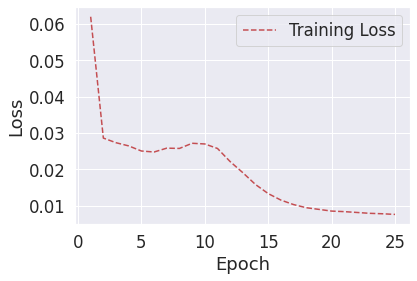

In [21]:
paths = ["../../data/ETH.csv"]

datasets, scaler = scaleData(paths)

# X_train, y_train = preprocessTestingData(datasets[0], LENGTH, LOOK_AHEAD_LENGTH)


model = trainModel(datasets, LENGTH)

# Test Model
## Evaluation Helpers

In [22]:
def sub_sample(arr1, arr2):
    return (arr1, arr2)

def evaluate_model(real_data, predicted_data, inherent_loss):
    real_data = real_data.reshape(len(real_data))
    predicted_data = predicted_data.reshape(len(predicted_data))

    real_diff = np.diff(real_data)
    predicted_diff = np.diff(predicted_data)

    correct_slopes = 0
    profit = 0
    for i in range(len(real_data)-1-LOOK_AHEAD_LENGTH):
        if np.sign(real_diff[i+LOOK_AHEAD_LENGTH-1]) == np.sign(predicted_diff[i]):
            correct_slopes = correct_slopes + 1
            
            # If we have a positive slope calculate profit
            if predicted_diff[i] > 1.75:
                # we subtract inherent_loss due to the limit market mechanics
                revenue = (real_data[i+1] - real_data[i]) - inherent_loss
                if revenue > 0:
                    # print(f"Found a profit where current value is {real_data[i+1]} last was {real_data[i]} net {revenue}")
                    profit = profit + revenue

        else:
            # We guessed wrong
            if predicted_diff[i] > 0:
                # we would have bought
                revenue = (real_data[i+1] - real_data[i]) - inherent_loss
                # print(f"Selling at a loss of {revenue}")
                profit = profit + revenue

    return (correct_slopes, profit)


In [23]:
def eval_model_on_dataset(actual, prediction, inherent_loss):
    # Subsample the test points, this seems to increase accuracy
    real_subbed, pred_subbed = sub_sample(actual, prediction)

    # Determine the number of cases in which we predicted a correct increase
    correct_slopes, profit = evaluate_model(real_subbed, pred_subbed, inherent_loss)

    print(f"Found {correct_slopes} out of {len(real_subbed)-1}")
    precent_success = (correct_slopes/(len(real_subbed)-1)) * 100
    print(f"{precent_success}%")
    print("Profit:", profit)
    return profit

## Test Model

In [26]:
def testModel(model, path_to_testing_dataset, quiet=False):

    datasets, scaler = scaleData([path_to_testing_dataset])

    hist, actual = preprocessTestingData(datasets[0], LENGTH, LOOK_AHEAD_LENGTH)

    pred = model.predict(hist)

    # print(pred)
    # for p in pred:
    # pred_transformed.append(scaler.inverse_transform(p))
    pred_transformed = scaler.inverse_transform(pred)
    actual_transformed = scaler.inverse_transform(actual[0])
    hist_transformed = scaler.inverse_transform(hist[0])

    # print(hist[0])
    if not quiet:
        plt.figure(figsize=(12,8))
        plt.plot(hist_transformed, color='blue', label='History')
        plt.plot(np.arange(200,240),pred_transformed[0], color='red', label='Prediction')
        plt.plot(np.arange(200,240),actual_transformed, color='purple', label='Actual')
        plt.title('ETH Price Prediction')
        plt.legend()
        plt.show()

    return eval_model_on_dataset(actual=actual_transformed, prediction=pred_transformed, inherent_loss=1.5)


[[0.49317795 0.49245068 0.49641433 ... 0.49858463 0.4886083  0.49285743]
 [0.49255544 0.49186626 0.49581596 ... 0.49787974 0.48797518 0.49227145]
 [0.49204943 0.4913926  0.49532646 ... 0.4973002  0.48745263 0.49179047]
 ...
 [0.40342933 0.4041856  0.40742975 ... 0.40409392 0.39939168 0.40397486]
 [0.40252826 0.4033046  0.40652168 ... 0.4031473  0.39850888 0.40308776]
 [0.4018082  0.40262857 0.40579072 ... 0.40236616 0.39780405 0.40240338]]


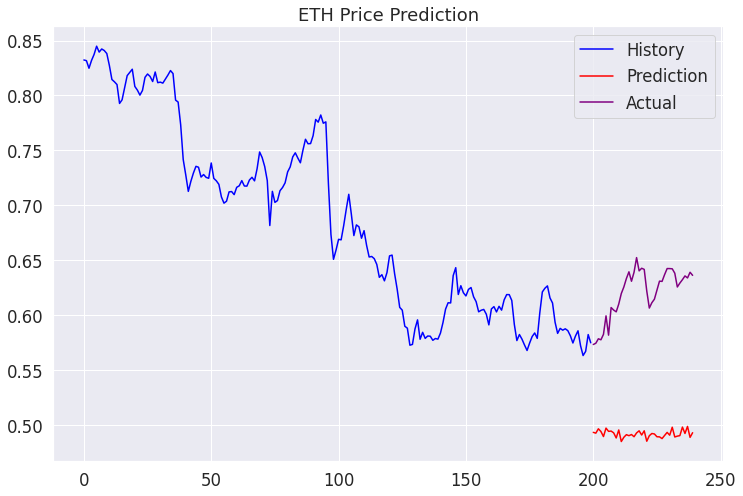

ValueError: cannot reshape array of size 624000 into shape (15600,)

In [27]:
testModel(model, "../../data/ETH.csv")

# Single Prediction

[1333.3694 1333.3608 1333.3683 1333.3586 1333.42   1333.4426 1333.3679
 1333.4108 1333.402  1333.3802 1333.4242 1333.4967 1333.392  1333.442
 1333.4491 1333.4288 1333.4247 1333.4714 1333.4447 1333.4283 1333.457
 1333.4928 1333.4924 1333.504  1333.4471 1333.5658 1333.4705 1333.5253
 1333.4679 1333.4674 1333.4912 1333.5399 1333.4407 1333.5503 1333.4884
 1333.582  1333.547  1333.5664 1333.5914 1333.5221]


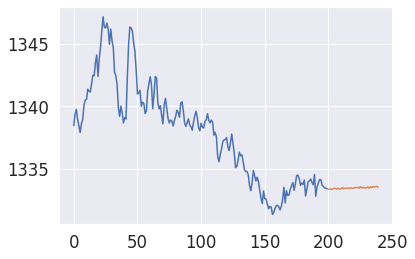

In [31]:
# For example, if we just want to predict the next timestep in the dataset we can prepare it as such:

# 1. get the [length] last points from the data set since that's what we care about
length = LENGTH
whole_df = pd.read_csv('../../data/ETH.csv')
# most_recent_period = np.array(recent_history)
recent_history = pd.DataFrame({'price': whole_df[["high_price","low_price"]].mean(axis=1)}).tail(length)
recent_history = recent_history.set_index(pd.DatetimeIndex(pd.to_datetime(whole_df['begins_at'].tail(length))))

# 2. convert to numpy array 
most_recent_period = np.array(recent_history)

# 3. normalize data
scaler = MinMaxScaler()
most_recent_period_scaled = scaler.fit_transform(most_recent_period)

# 4. reshape to the 3D tensor we expected (1, length, 1)
most_recent_period_scaled_shaped = most_recent_period_scaled.reshape((1, length, 1))

# 5. Predict
prediction = model.predict(most_recent_period_scaled_shaped)
# print(prediction[0])
# 6. Un-normalize the data
result = scaler.inverse_transform(prediction)
recent_history_unscaled = scaler.inverse_transform(most_recent_period_scaled)
recent_history.price = recent_history_unscaled

print(result[0])
pred_df = pd.DataFrame(result[0])
# pred_df = pred_df.set_index(pd.DatetimeIndex(pd.date_range(recent_history.index[-1], periods=len(result[0]), freq="15s")))

plt.plot(recent_history_unscaled)
plt.plot(np.arange(200, 240),result[0])
plt.show()

# Prediction Success Evaluation

In [ ]:
model.save("my_model")

In [ ]:
pink = models.load_model("my_model")

In [ ]:
profits = []
for length in np.arange(5, 360, 5):
    for sub in np.arange(10, 480, 5):
        try:
            LENGTH = length
            SUBSAMPLING = sub
            model = trainModel(datasets, LENGTH, quiet=True)
            profit = testModel(model, "../../data/MorningTest.csv", quiet=True)
            profits.append((profit, length, sub))
            print(sorted(profits, key=lambda tup: -tup[0])[0:20])
        except:
            pass


In [ ]:
print("FINAL RESULTS")
sorted(profits, key=lambda tup: tup[0])[0:20]
